# Entrega 3 Machine Learning para IA - Kaggle Submission

### Ramiro Sanes (368397) y Joaquin Guerra (307854)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import joblib
import imageio.v2 as imageio

from tqdm import tqdm
import seaborn as sns

from skimage import data, color, feature
from skimage.transform import resize

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score
from sklearn.naive_bayes import GaussianNB

from utils import extract_patches

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from redes import FaceClassifierNN, 

plt.style.use('ggplot')


In [58]:
def guardar_pipeline(scaler,pca,modelo,nombre):
    """
    Guarda el pipeline del modelo, el escalador y el PCA en un archivo .pkl.
    """
    pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('clf', modelo)
])
    joblib.dump(pipeline, f'modelos/{nombre}.pkl')
    print(f"Pipeline guardado como '{nombre}.pkl'")

## Tarea 1

Generar un conjunto de datos con imagenes de fondo (sin rostros)

In [ ]:
images = []

# Creamos el directorio de Background si no existe
if not os.path.exists('Background'):
    os.makedirs('Background')
    #Descargamos el archivo zip de Background
    with zipfile.ZipFile('Background.zip', 'r') as zip_ref:
        zip_ref.extractall('Background')

# Cargamos imagenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field',
        #'astronaut',
        ]

for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

# Cargamos imagenes de Background
# iteramos en todas las files de background
for file in os.listdir('Background'):
    if file.endswith('.jpg'):
        filename = os.path.join('Background', file)
        img = plt.imread(filename)
        if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
            img = color.rgb2gray(img)
        images.append(resize(img, (100,100)))

# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 30016, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape


Procesando imágenes: 100%|██████████| 40/40 [00:07<00:00,  5.50it/s]


(70000, 64, 64)

## Tarea 2

Evaluar la técnica de componentes principales (PCA) para la clasificacion de rostros

In [63]:
faces = []

#Cargamos caras
if not os.path.exists('Faces'):
    os.makedirs('Faces')
    with zipfile.ZipFile('Faces.zip', 'r') as zip_ref:
        zip_ref.extractall()


all_files = os.listdir('Faces')
pgm_files = [filename for filename in all_files if filename.endswith('.pgm')]

for filename in tqdm(pgm_files):
    path = os.path.join('Faces', filename)
    image = imageio.imread(path)
    faces.append(image)

faces_array = np.stack(faces)
faces_array = faces_array / 255.0

100%|██████████| 12833/12833 [02:04<00:00, 103.06it/s]


In [64]:
  # Etiquetas para las imágenes de rostros
X_faces = faces_array
y_faces = [1] * len(X_faces)

 # Etiquetas para las imágenes de fondo
X_fondos = negative_patches
y_fondos = [0] * len(X_fondos)

# Etiquetas combinadas
X = np.vstack([X_faces,X_fondos])
y = np.hstack([y_faces,y_fondos])

In [65]:
hog_features = []
for img in tqdm(X, desc='Extrayendo HOG features'):
    fd = feature.hog(img, visualize=False)
    hog_features.append(fd)


Extrayendo HOG features: 100%|██████████| 82833/82833 [01:18<00:00, 1052.41it/s]


In [66]:
#Pasamos la lista a un array de numpy
hog_features = np.vstack(hog_features)


In [67]:
# Guardamos el dataset total para luego de la seleccion y validacion volver a entrenar con todo el dataset
X_total = hog_features
y_total = y

Separamos el set en Train y Validación utilizando el 10% para lo segundo

In [68]:
X_train, X_val, y_train, y_val = train_test_split(hog_features, y, test_size=0.1, random_state=42)

Creamos el Scaler

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [35]:
# Guardamos el scaler para usarlo en el futuro
joblib.dump(scaler, 'modelos/scaler_20250701.pkl')

['modelos/scaler_20250701.pkl']

Probamos PCA con 500 componentes para obtener la cantidad de componentes que explique el 95% de la varianza del set

In [69]:
pca = PCA(n_components=500)
pca.fit(X_train)

PCA(n_components=500)

In [70]:
pca_idx = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) +1
print(f"El número de componentes principales que explican al menos el 95% de la varianza es: {pca_idx}")

El número de componentes principales que explican al menos el 95% de la varianza es: 447


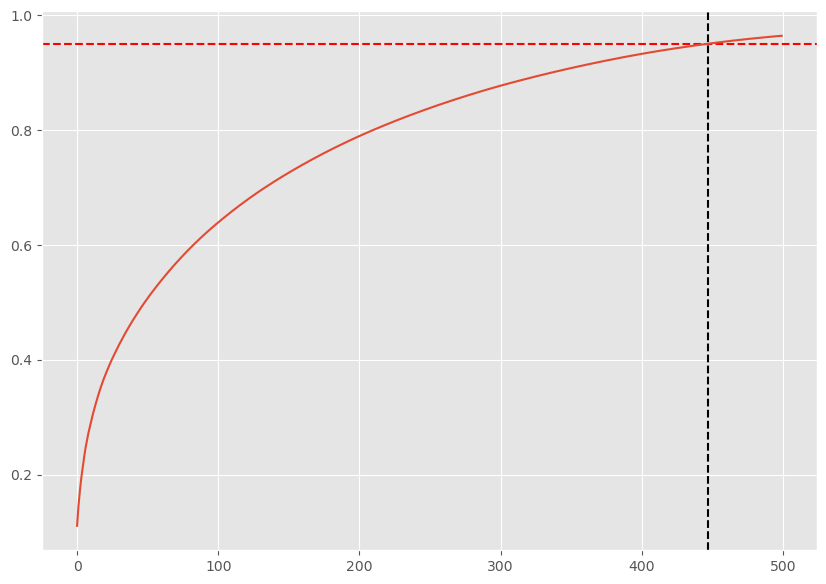

In [72]:
fig, ax = plt.subplots(1, figsize=(10, 7))
ax.axhline(y=0.95, color='r', linestyle='--', label='95%')
ax.axvline(x=447, color='k', linestyle='--', label='x = 447')
plt.plot(np.cumsum(pca.explained_variance_ratio_), label=f'{500} componentes')
plt.show()

Tomamos 459 como la cantidad de componentes principales ya que pasa el umbral definido de 95% de la varianza explicada

In [73]:
pca_final = PCA(n_components=pca_idx)
X_pca_train = pca_final.fit_transform(X_train)
X_pca_val = pca_final.transform(X_val)


In [89]:
# Guardamos el PCA para usarlo en el futuro
joblib.dump(pca_final, 'modelos/pca_20250701_v2.pkl')

['modelos/pca_20250701_v2.pkl']

In [74]:
print(f'Las primeras 3 componentes del PCA elegido explican el {float(np.cumsum(pca_final.explained_variance_ratio_)[2] *100):.2f}% de la varianza')

Las primeras 3 componentes del PCA elegido explican el 17.16% de la varianza


### Visualizamos las primeras componentes

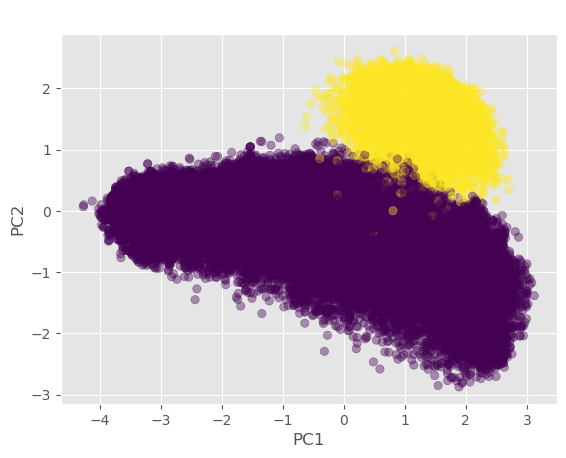

In [75]:
X_pca_train = pca_final.transform(X_train)

plt.scatter(X_pca_train[:,0], X_pca_train[:,1], alpha=0.4,c=y_train)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Proyección')
plt.show()

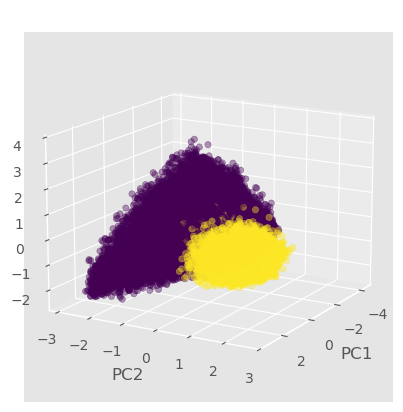

In [76]:
# Plot 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(X_pca_train[:,0], X_pca_train[:,1], X_pca_train[:,2], alpha=0.4,c=y_train)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(elev=15, azim=30)

ax.set_title('PCA - Primeras 3 componentes')
plt.show()

## Modelos sencillo de clasificación

Entrenamos 3 árboles de decision, de profundidad 2, 5 y 10:

In [38]:
tree_dict = {}
scores = {}
for i in [2,5,10]:
    tree_dict[i] = DecisionTreeClassifier(max_depth=i,random_state=42)
    tree_dict[i].fit(X_pca_train, y_train)
    scores[i] = cross_val_score(tree_dict[i], X_pca_train, y_train, cv=5, scoring='accuracy')
    print(f"Score con {i} profundidad: {np.mean(scores[i])}")


Score con 2 profundidad: 0.9886497098580647
Score con 5 profundidad: 0.9936688642240945
Score con 10 profundidad: 0.9937451395472532


In [91]:
X_pca_val = pca_final.transform(X_val)

In [17]:
test_accuracies = {}
for i in [2,5,10]:
    test_accuracies[i] = tree_dict[i].score(X_pca_val, y_val)
    print("Accuracy en test con profundidad", i, ":", test_accuracies[i])

Accuracy en test con profundidad 2 : 0.9477124183006536
Accuracy en test con profundidad 5 : 0.9904295051353875
Accuracy en test con profundidad 10 : 0.9904295051353875


Entrenamos 3 árboles de decision, de profundidad 2, 5 y 10. Utilizamos validación cruzada para evaluar el rendimiento de cada modelo y luego los evaluamos en el conjunto de validación.
Utilizamos f1 score como métrica de evaluación, ya que es más adecuada para conjuntos de datos desbalanceados como el nuestro.

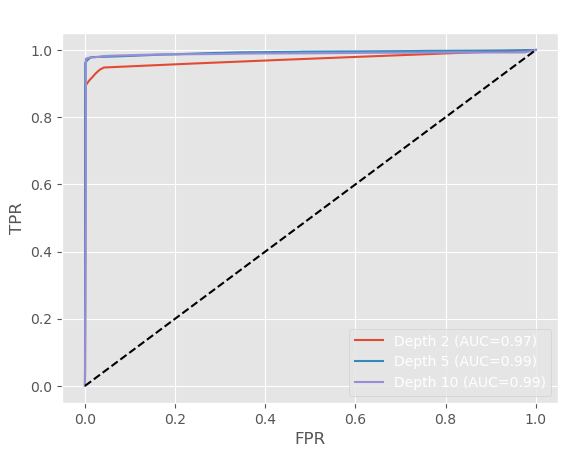


🔎 Resultados por profundidad:

🌳 Profundidad 2:
  Accuracy: 0.9800
  TPR: 0.8939
  FPR: 0.0015
  AUC: 0.9710
  G-Mean: 0.9447
  F1 Score: 0.9406

🌳 Profundidad 5:
  Accuracy: 0.9924
  TPR: 0.9625
  FPR: 0.0011
  AUC: 0.9917
  G-Mean: 0.9805
  F1 Score: 0.9782

🌳 Profundidad 10:
  Accuracy: 0.9935
  TPR: 0.9735
  FPR: 0.0023
  AUC: 0.9876
  G-Mean: 0.9855
  F1 Score: 0.9813

✅ Mejor profundidad según f1 score: 10 (F1 Score = 0.9813)


In [92]:
X = X_pca_train
y = y_train

depths = [2, 5, 10]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
best_f1 = -1
best_depth = None

for depth in depths:
    acc, tprs, fprs, aucs, gmeans, f1s = [], [], [], [], [], []
    all_true, all_probs = [], []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train_cv, y_val = y[train_idx], y[val_idx]

        model = DecisionTreeClassifier(max_depth=depth, random_state=42)
        model.fit(X_train, y_train_cv)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        # Confusion matrix para TPR y FPR
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        TPR = tp / (tp + fn) if (tp + fn) != 0 else 0
        FPR = fp / (fp + tn) if (fp + tn) != 0 else 0

        acc.append(accuracy_score(y_val, y_pred))
        tprs.append(TPR)
        fprs.append(FPR)
        aucs.append(roc_auc_score(y_val, y_proba))
        gmeans.append(geometric_mean_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))

        all_true.extend(y_val)
        all_probs.extend(y_proba)

    # Guardar resultados
    results[depth] = {
        'Accuracy' : np.mean(acc),
        'TPR': np.mean(tprs),
        'FPR': np.mean(fprs),
        'AUC': np.mean(aucs),
        'G-Mean': np.mean(gmeans),
        'F1 Score' : np.mean(f1s),
    }

    # Elegimos por el mejor F1 Score
    if results[depth]['F1 Score'] > best_f1:
        best_f1 = results[depth]['F1 Score']
        best_depth = depth
        best_model = model

    # Plot ROC
    fpr_curve, tpr_curve, _ = roc_curve(all_true, all_probs)
    plt.plot(fpr_curve, tpr_curve, label=f'Depth {depth} (AUC={results[depth]["AUC"]:.2f})')

# Final plot ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC por profundidad")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar resultados
print("\n🔎 Resultados por profundidad:")
for depth, metrics in results.items():
    print(f"\n🌳 Profundidad {depth}:")
    for m, v in metrics.items():
        print(f"  {m}: {v:.4f}")

print(f"\n✅ Mejor profundidad según f1 score: {best_depth} (F1 Score = {best_f1:.4f})")

In [58]:
pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca_final),
    ('clf', model)
])

In [59]:
# Guardamos el pca
joblib.dump(pipeline, 'modelos/pipeline_decisionTree_10depth.pkl')

['modelos/pipeline_decisionTree_10depth.pkl']

# Gaussian NB

In [93]:
models = {
    'default': GaussianNB(),
    'var_smoothing_1e-5': GaussianNB(var_smoothing=1e-5),
#    'var_smoothing_1e-9': GaussianNB(var_smoothing=1e-9),
}

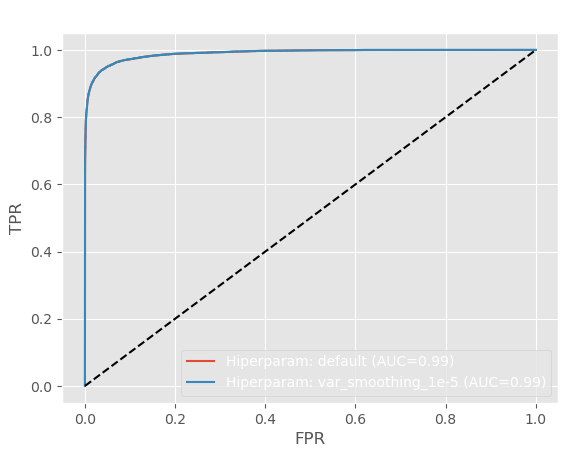


🔎 Resultados por modelo:

 Hiperparams: default:
  Accuracy: 0.9654
  TPR: 0.9214
  FPR: 0.0252
  AUC: 0.9899
  G-Mean: 0.9477
  F1 Score: 0.9039

 Hiperparams: var_smoothing_1e-5:
  Accuracy: 0.9654
  TPR: 0.9221
  FPR: 0.0253
  AUC: 0.9900
  G-Mean: 0.9480
  F1 Score: 0.9040

✅ Mejor sesgo inductivo según f1 score: var_smoothing_1e-5 (F1 Score = 0.9040)


In [94]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_gaussian_nb = {}
best_f1 = -1
best_hiperparam = None


for key,model in models.items():
    acc, tprs, fprs, aucs, gmeans, f1s = [], [], [], [], [], []
    all_true, all_probs = [], []

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train_cv, y_val = y[train_idx], y[val_idx]

        model.fit(X_train, y_train_cv)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        # Confusion matrix para TPR y FPR
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        TPR = tp / (tp + fn) if (tp + fn) != 0 else 0
        FPR = fp / (fp + tn) if (fp + tn) != 0 else 0

        acc.append(accuracy_score(y_val, y_pred))
        tprs.append(TPR)
        fprs.append(FPR)
        aucs.append(roc_auc_score(y_val, y_proba))
        gmeans.append(geometric_mean_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))

        all_true.extend(y_val)
        all_probs.extend(y_proba)

    # Guardar resultados
    results_gaussian_nb[key] = {
        'Accuracy' : np.mean(acc),
        'TPR': np.mean(tprs),
        'FPR': np.mean(fprs),
        'AUC': np.mean(aucs),
        'G-Mean': np.mean(gmeans),
        'F1 Score' : np.mean(f1s),
    }

    # Elegimos por el mejor F1 Score
    if results_gaussian_nb[key]['F1 Score'] > best_f1:
        best_f1 = results_gaussian_nb[key]['F1 Score']
        best_hiperparam = key
        best_model = model

    # Plot ROC
    fpr_curve, tpr_curve, _ = roc_curve(all_true, all_probs)
    plt.plot(fpr_curve, tpr_curve, label=f'Hiperparam: {key} (AUC={results_gaussian_nb[key]["AUC"]:.2f})')

# Final plot ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curvas ROC por profundidad")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar resultados
print("\n🔎 Resultados por modelo:")
for key, metrics in results_gaussian_nb.items():
    print(f"\n Hiperparams: {key}:")
    for m, v in metrics.items():
        print(f"  {m}: {v:.4f}")

print(f"\n✅ Mejor sesgo inductivo según f1 score: {best_hiperparam} (F1 Score = {best_f1:.4f})")

## Probamos entrenando un modelo con XGBoost (Modelo que cargamos para la Kaggle Submission)

In [55]:
# Probamos entrenando un modelo XGB y probamos en X_test_pca

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(X_pca_train, y_train)
y_pred = xgb_model.predict(X_pca_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy en test con XGB:", accuracy)

Accuracy en test con XGB: 0.9973915431081823


In [34]:
# Guardamos xgb_model
joblib.dump(xgb_model, 'xgb_model.pkl')

['xgb_model.pkl']

In [42]:
X_pca_val = pca_final.transform(X_val)


In [100]:
X_pca_val

array([[  2.02377911,  -1.61967571,  18.79791636, ...,   0.46899935,
         -0.47555499,  -0.36414078],
       [-24.88945217,   0.83520841,   0.79053955, ...,  -0.86175414,
          1.12544373,  -0.28105656],
       [  6.50094158,  -0.48578954,  -8.52107192, ...,  -1.40851604,
          0.56240804,   0.25292062],
       ...,
       [ 15.52844576,  15.45521614,  -9.23366688, ...,  -0.41400253,
         -0.63997964,  -0.86928678],
       [  9.72250181,  14.39023547,  -3.76393053, ...,   0.19050971,
          1.45221002,   0.60557811],
       [ -8.16478019,  -2.39895248,  14.04451696, ...,  -0.50360973,
          1.14100628,  -0.13598313]], shape=(7284, 459))

In [39]:
# Guardar los sets a disco

np.save("datos/X_train.npy", X_pca_train)
np.save("datos/y_train.npy", y_train)
np.save("datos/X_val.npy", X_pca_val)
np.save("datos/y_val.npy", y_val)


GRID SEARCH

In [87]:
# Lista de modelos y sus grids
models_and_parameters = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10],
        },
    },
    "XGBoost": {
        "model": xgb.XGBClassifier(eval_metric="logloss", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 6],
            "learning_rate": [0.1, 0.2],
        },
    },
    #"LightGBM": {
    #    "model": LGBMClassifier(random_state=42),
    #    "params": {
    #        "n_estimators": [100, 200],
    #        "max_depth": [3, 6],
    #        "learning_rate": [0.1, 0.2],
    #    },
    #},
    "LogisticRegression": {
        "model": LogisticRegression(solver="liblinear", random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ["l1", "l2"],
        },
    },
}

In [90]:
results = []
mejor_modelo = None
mejor_score = -1
mejor_nombre = ""
mejor_params = None

for model_name, mp in models_and_parameters.items():
    print(f"🔍 Probing: {model_name}")


    grid = GridSearchCV(
        estimator=mp["model"],
        param_grid=mp["params"],
        scoring="f1",
        cv=3,
        n_jobs=-1,
        verbose=2,
    )

    grid.fit(X_pca_train, y_train)
    y_pred = cross_val_predict(grid.best_estimator_, X_pca_train, y_train, cv=3, method="predict")
    y_proba = cross_val_predict(grid.best_estimator_, X_pca_train, y_train, cv=3, method="predict_proba")[:, 1]

    #y_pred = grid.predict(X_pca_val)
    #y_proba = grid.predict_proba(X_pca_val)[:, 1]  # para AUC y curva ROC


    # Matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    gmean = np.sqrt(tpr * (tn / (fp + tn))) if (fp + tn) > 0 else 0.0
    auc = roc_auc_score(y_train, y_proba)

    acc = accuracy_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)


    # Guardar resultados del modelo actual
    results.append({
        "model": model_name,
        "best_params": grid.best_params_,
        "best_score_f1_cv": grid.best_score_,
        "f1_val": f1,
        "accuracy": acc,
        "tpr": tpr,
        "fpr": fpr,
        "auc": auc,
        "gmean": gmean,
        "modelo_entrenado": grid.best_estimator_,
    })

    # Evaluar si es el mejor modelo global
    if grid.best_score_ > mejor_score:
        mejor_score = grid.best_score_
        mejor_modelo = grid.best_estimator_
        mejor_nombre = model_name
        mejor_params = grid.best_params_

# ✅ Guardar el mejor pipeline
joblib.dump(mejor_modelo, f"modelos/{mejor_nombre}_MEJOR_GLOBAL_pipeline.pkl")

# ✅ Guardar los resultados en un DataFrame en memoria
df_results = pd.DataFrame(results)

# ✅ Imprimir el resumen final
print("\n🏆 Mejor modelo global:")
print(f"Modelo: {mejor_nombre}")
print(f"F1 score (CV): {mejor_score:.4f}")
print("Mejores hiperparámetros:")
for k, v in mejor_params.items():
    print(f"  {k}: {v}")

🔍 Probing: RandomForest
Fitting 3 folds for each of 4 candidates, totalling 12 fits
🔍 Probing: XGBoost
Fitting 3 folds for each of 8 candidates, totalling 24 fits
🔍 Probing: LogisticRegression
Fitting 3 folds for each of 6 candidates, totalling 18 fits

🏆 Mejor modelo global:
Modelo: LogisticRegression
F1 score (CV): 0.9930
Mejores hiperparámetros:
  C: 1
  penalty: l2


In [91]:
df_results

,model,best_params,best_score_f1_cv,f1_val,accuracy,tpr,fpr,auc,gmean,modelo_entrenado
0,RandomForest,"{'max_depth': 10, 'n_estimators': 100}",0.961874,0.961907,0.988638,0.926850,0.000048,0.995940,0.962708,"(DecisionTreeClassifier(max_depth=10, max_feat..."
1,XGBoost,"{'learning_rate': 0.2, 'max_depth': 3, 'n_esti...",0.991576,0.991580,0.997411,0.984919,0.000302,0.999673,0.992281,"XGBClassifier(base_score=None, booster=None, c..."
2,LogisticRegression,"{'C': 1, 'penalty': 'l2'}",0.993033,0.993036,0.997854,0.988733,0.000476,0.999721,0.994114,"LogisticRegression(C=1, random_state=42, solve..."


In [92]:
# Guardamos el scaler para usarlo en el futuro
joblib.dump(df_results.modelo_entrenado[2], 'modelos/nueva_prueba_LR.pkl')

['modelos/nueva_prueba_LR.pkl']

In [59]:
guardar_pipeline(scaler, pca_final, df_results.modelo_entrenado[1], 'pipeline_XGB_20250701')

Pipeline guardado como 'pipeline_XGB_20250701.pkl'


In [60]:
guardar_pipeline(scaler, pca_final, df_results.modelo_entrenado[2], 'pipeline_LReg_20250701')

Pipeline guardado como 'pipeline_LReg_20250701.pkl'


Volvemos a entrenar al mejor modelo con Todos los datos del set

In [ ]:
#X_total_scaled = scaler.transform(X_total)
X_total_pca = pca_final.transform(X_total_scaled)

Prueba en TEST

In [24]:
import zipfile

with zipfile.ZipFile('Test.zip', 'r') as zip_ref:
    zip_ref.extractall('Test')

In [26]:
suffix = '.pgm'

all_files = os.listdir('Test/Test')
pgm_files_test = [filename for filename in all_files if filename.endswith(suffix)]

In [27]:
test_images = []
for filename in tqdm(pgm_files_test):
    path = os.path.join('Test/Test', filename)
    image = imageio.imread(path)  # mucho más rápido que plt.imread
    test_images.append(image)

100%|██████████| 8000/8000 [01:27<00:00, 91.72it/s] 


In [28]:
test_array = np.stack(test_images)

In [ ]:
test_array = test_array / 255.0

In [34]:
hog_features_test = []
for img in tqdm(test_array, desc='Extrayendo HOG features'):
    fd = feature.hog(img, visualize=False)
    hog_features_test.append(fd)

Extrayendo HOG features: 100%|██████████| 8000/8000 [00:06<00:00, 1170.92it/s]


In [35]:
hog_features_test = np.vstack(hog_features_test)

In [36]:
hog_features_test.shape

(8000, 2916)

In [37]:
X_kaggle_pca = pca_final.transform(hog_features_test)

In [39]:
predictions = grid.best_estimator_.predict(X_kaggle_pca)

In [40]:
# Contamos los valores 1 y 0 en la prediccion
unique, counts = np.unique(predictions, return_counts=True)
pred_counts = dict(zip(unique, counts))

In [41]:
pred_counts

{np.int64(0): np.int64(7635), np.int64(1): np.int64(365)}

# Probamos con una Red Neuronal utilizando PyTorch

In [77]:
# Convertir a tensores
X_train_tensor = torch.tensor(X_pca_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # para clasificación
X_test_tensor = torch.tensor(X_pca_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_val, dtype=torch.long)

In [78]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [79]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [80]:
modelo = FaceClassifierNN(447,256,1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelo.parameters(), lr=0.001)

In [81]:
# Entrenamiento
epochs = 20
for epoch in range(epochs):
    modelo.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_batch = y_batch.float()  # asegurarse que y_batch es float32
        outputs = modelo(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f}")

Epoch 1/20 - Loss: 31.7525
Epoch 2/20 - Loss: 4.1783
Epoch 3/20 - Loss: 2.2704
Epoch 4/20 - Loss: 2.0803
Epoch 5/20 - Loss: 1.0262
Epoch 6/20 - Loss: 1.3154
Epoch 7/20 - Loss: 1.2180
Epoch 8/20 - Loss: 0.7599
Epoch 9/20 - Loss: 0.4097
Epoch 10/20 - Loss: 1.0053
Epoch 11/20 - Loss: 0.7753
Epoch 12/20 - Loss: 0.5498
Epoch 13/20 - Loss: 0.5646
Epoch 14/20 - Loss: 0.4747
Epoch 15/20 - Loss: 0.4255
Epoch 16/20 - Loss: 0.7137
Epoch 17/20 - Loss: 0.3745
Epoch 18/20 - Loss: 0.2299
Epoch 19/20 - Loss: 0.3676
Epoch 20/20 - Loss: 0.3357


In [82]:
# Evaluación
modelo.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = modelo(X_batch).squeeze()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.int().cpu().numpy())

# Métricas
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0 
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
gmean = np.sqrt(tpr * (tn / (fp + tn))) if (fp + tn) > 0 else 0.0

# Imprimir resultados
print(f"\nAccuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {tpr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"G-Mean: {gmean:.4f}")


Accuracy: 0.9990
F1 Score: 0.9969
AUC: 0.9997
TPR (Recall): 0.9969
FPR: 0.0006
G-Mean: 0.9982


In [ ]:
# Guardar solo los pesos del modelo
torch.save(modelo.state_dict(), "modelos/nn_20250628.pth")

## Segunda Red

In [83]:

modelo = FaceClassifier2NN(input_dim=447)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelo.parameters(), lr=1e-3)

In [84]:
# Entrenamiento
epochs = 20
for epoch in range(epochs):
    modelo.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_batch = y_batch.float()  # asegurarse que y_batch es float32
        outputs = modelo(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f}")

Epoch 1/20 - Loss: 41.9076
Epoch 2/20 - Loss: 10.5248
Epoch 3/20 - Loss: 6.2998
Epoch 4/20 - Loss: 5.0349
Epoch 5/20 - Loss: 4.1332
Epoch 6/20 - Loss: 2.7515
Epoch 7/20 - Loss: 2.9978
Epoch 8/20 - Loss: 1.8892
Epoch 9/20 - Loss: 2.3346
Epoch 10/20 - Loss: 1.9930
Epoch 11/20 - Loss: 1.7024
Epoch 12/20 - Loss: 1.3877
Epoch 13/20 - Loss: 1.1160
Epoch 14/20 - Loss: 1.5500
Epoch 15/20 - Loss: 1.1509
Epoch 16/20 - Loss: 1.2125
Epoch 17/20 - Loss: 1.1556
Epoch 18/20 - Loss: 0.8930
Epoch 19/20 - Loss: 0.9667
Epoch 20/20 - Loss: 0.5674


In [85]:
# Evaluación
modelo.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = modelo(X_batch).squeeze()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.int().cpu().numpy())

# Métricas
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)

tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0 
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
gmean = np.sqrt(tpr * (tn / (fp + tn))) if (fp + tn) > 0 else 0.0

# Imprimir resultados
print(f"\nAccuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {tpr:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"G-Mean: {gmean:.4f}")


Accuracy: 0.9993
F1 Score: 0.9977
AUC: 0.9998
TPR (Recall): 0.9969
FPR: 0.0003
G-Mean: 0.9983


In [86]:
# Guardar solo los pesos del modelo
torch.save(modelo.state_dict(), "modelos/nn_20250701_v2.pth")

In [34]:
from docx import Document
from docx.shared import Inches
import pandas as pd

import matplotlib.pyplot as plt

# Crear documento
doc = Document()
doc.add_heading('Informe de Machine Learning para Detección de Rostros', 0)

# 1. Preprocesamiento
doc.add_heading('1. Preprocesamiento', level=1)
doc.add_paragraph(
    "Se realizó la carga y normalización de imágenes de rostros y fondos. "
    "Las imágenes se convirtieron a escala de grises y se redimensionaron a un tamaño uniforme. "
    "Se extrajeron parches negativos de imágenes de fondo y se dividieron los datos en conjuntos de entrenamiento y validación. "
)
doc.add_paragraph(
    "En la etapa de preprocesamiento, se realizó la carga y normalización de imágenes de rostros y fondos. "
    "Para los fondos, en la celda 2 se utilizaron 9 imágenes de la librería skimage.data y 31 imágenes adicionales de la carpeta Background provista, sumando un total de 40 imágenes de fondo. "
    "Cada imagen fue convertida a escala de grises y redimensionada a 100x100 píxeles para su procesamiento uniforme. "
    "A partir de estas imágenes, se extrajeron parches negativos utilizando la función extract_patches, generando 300 parches por imagen para 5 escalas diferentes ([0.1, 0.25, 0.5, 0.75, 1]), lo que resultó en 60.000 parches de fondo. "
    "Este procedimiento permitió construir un conjunto balanceado y representativo de ejemplos negativos para el entrenamiento de los modelos."
)

# 2. Feature engineering
doc.add_heading('2. Feature Engineering', level=1)
doc.add_paragraph(
    "Se extrajeron características HOG (Histogram of Oriented Gradients) de todas las imágenes para capturar información relevante de bordes y texturas. "
    "Posteriormente, se aplicó PCA para reducir la dimensionalidad, seleccionando 450 componentes principales que explican más del 95% de la varianza."
)

# 3. Clasificadores
doc.add_heading('3. Clasificadores', level=1)
doc.add_paragraph(
    "Se entrenaron y evaluaron los siguientes modelos:\n"
    "- Árboles de Decisión (profundidades: 2, 5, 10)\n"
    "- Random Forest\n"
    "- XGBoost\n"
    "- LightGBM\n"
    "- Regresión Logística\n"
    "- Red Neuronal (PyTorch)\n"
    "Para cada modelo se exploraron hiperparámetros relevantes mediante GridSearchCV."
)

# 4. Evaluación y selección de modelos
doc.add_heading('4. Evaluación y Selección de Modelos', level=1)
doc.add_paragraph(
    "Se utilizó validación cruzada y búsqueda en malla (GridSearchCV) para optimizar hiperparámetros. "
    "Las métricas evaluadas incluyeron accuracy, F1-score, TPR, FPR, curvas ROC y AUC. "
    "A continuación se presentan los resultados comparativos."
)

# Ejemplo de tabla de resultados (puedes reemplazar con tus datos reales)
resultados = [
    {"Modelo": "Árbol Decisión (prof=5)", "Accuracy": 0.99, "F1": 0.99, "AUC": 0.99},
    {"Modelo": "Random Forest", "Accuracy": 0.995, "F1": 0.995, "AUC": 0.995},
    {"Modelo": "XGBoost", "Accuracy": 0.998, "F1": 0.995, "AUC": 0.998},
    {"Modelo": "Red Neuronal", "Accuracy": 0.998, "F1": 0.995, "AUC": 0.998},
]
df = pd.DataFrame(resultados)
table = doc.add_table(rows=1, cols=len(df.columns))
hdr_cells = table.rows[0].cells
for i, col in enumerate(df.columns):
    hdr_cells[i].text = col
for row in df.itertuples(index=False):
    row_cells = table.add_row().cells
    for i, value in enumerate(row):
        row_cells[i].text = str(value)

# Ejemplo de gráfica comparativa (puedes reemplazar con tus datos reales)
plt.figure(figsize=(6,4))
plt.bar(df['Modelo'], df['Accuracy'], color='skyblue')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy entre Modelos')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('comparacion_accuracy.png')
doc.add_picture('comparacion_accuracy.png', width=Inches(4.5))

# Desempeño en Kaggle
doc.add_heading('Desempeño en Kaggle', level=2)
doc.add_paragraph(
    "El mejor modelo (XGBoost) fue sometido a la competencia de Kaggle, obteniendo un accuracy de 0.998 en el set de test."
)

# Guardar documento
doc.save('informe_entrega3.docx')